In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf, ccf
from scipy.io import loadmat
import h5py

np.random.seed(2024)

# 1. Full QG

## load data

In [2]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo10_beta22_K16.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (16, 16, 100000)
psi_hat_t.dtype complex128


## compute eigenvalues and eigenvectors

In [3]:
# compute eigenvalues and eigenvectors
omega1 = np.zeros((K,K), dtype=complex)
omega2 = np.zeros((K,K), dtype=complex)
r1 = np.zeros((K,K,2), dtype=complex)
r2 = np.zeros((K,K,2), dtype=complex)
beta_value = beta; kd_value = kd+0j; U_value = U;
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky):  
        k_mag = kx_value**2 + ky_value**2
        if k_mag == 0:  # Skip the case where k_mag is 0 to avoid division by zero
            continue

        # Compute omega_k1 and omega_k2
        omega_k1 = (kx_value * (beta_value * (kd_value**2 + 2 * k_mag) + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2))) / (2 * k_mag * (kd_value**2 + k_mag))
        omega_k2 = kx_value * (beta_value * (kd_value**2 + 2 * k_mag) - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (2 * k_mag * (kd_value**2 + k_mag))
        omega1[iky,ikx] = omega_k1; omega2[iky,ikx] = omega_k2

        # Compute r_k1 and r_k2
        r_k1 = np.array([
            [- (2 * U_value * k_mag**2 - np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r_k2 = np.array([
            [- (2 * U_value * k_mag**2 + np.sqrt(beta_value**2 * kd_value**4 + 4 * k_mag**2 * (-kd_value**4 + k_mag**2) * U_value**2)) / (kd_value**2 * (beta_value - 2 * k_mag * U_value))],
            [1]
        ], dtype=complex)
        r1[iky,ikx,:] = np.squeeze(r_k1); r2[iky,ikx,:] = np.squeeze(r_k2)


In [4]:
# save data
eigens = {
    'omega1': omega1,
    'omega2': omega2,
    'r1': r1,
    'r2': r2
}
np.save('../data/eigens_K16_beta22.npy', eigens)

In [5]:
np.where(np.isnan(r1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

## Calibration of OU Process

In [3]:
# load eigenvectors
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']

In [8]:
# Model calibration using eigenmodes recovered based on eigenvectors
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
omega_est_ccf = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 0

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
        x1_, _ = curve_fit(CCF, tt, ccf_psi1, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        omega1_est_ccf = x1_[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        omega_est_ccf[iky,ikx,0] = omega1_est_ccf;
        
        x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
        x2_, _ = curve_fit(CCF, tt, ccf_psi2, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        omega2_est_ccf = x2_[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;
        omega_est_ccf[iky,ikx,1] = omega2_est_ccf;

In [9]:
# calibrate the sign of ACF-estimated omega_k according to CCF-estimated omega_k
sign1 = np.sign(omega_est)
sign2 = np.sign(omega_est_ccf)
sign2_corrected = np.where((sign1 == 0) & (sign2 == 0), 0, sign2)
omega_est_ca = np.abs(omega_est) * sign2_corrected

In [10]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega_ccf': omega_est_ccf,
    'omega_acf': omega_est,
    'omega': omega_est_ca,
    'f': f_est,
    'sigma': sigma_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K16_beta22.npy', est_params)

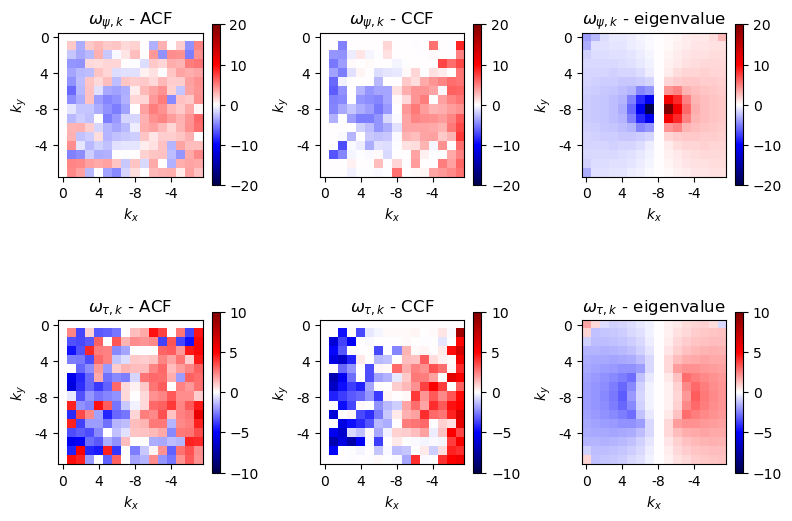

In [11]:
# Create a figure for the plots
fig = plt.figure(figsize=(8, 6))

matrix1 = omega_est_ca[:,:,0]
matrix2 = omega_est_ccf[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)
kx_shift = np.roll(kx, shift=K//2, axis=0) 

lim1 = 20
lim2 = 10
# Plot for matrix1
ax1 = fig.add_subplot(231)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax1.set_title(r'$\omega_{\psi,k}$ - ACF')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::K//4].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1))

# Plot for matrix2
ax2 = fig.add_subplot(232)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(matrix2, cmap='seismic', vmin=-lim1, vmax=lim1)
ax2.set_title(r'$\omega_{\psi,k}$ - CCF')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::K//4].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega_est_ca[:,:,1]
matrix2 = omega_est_ccf[:,:,1]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax3 = fig.add_subplot(234)  # 1 row, 2 columns, 1st subplot
surf1 = ax3.imshow(matrix1, cmap='seismic', vmin=-lim2, vmax=lim2)
ax3.set_title(r'$\omega_{\tau,k}$ - ACF')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::K//4].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1)) / 100

# Plot for matrix2
ax4 = fig.add_subplot(235)  # 1 row, 2 columns, 2nd subplot
surf2 = ax4.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax4.set_title(r'$\omega_{\tau,k}$ - CCF')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::K//4].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega1.real # np.abs(omega[:,:,0])-np.abs(omega_est[:,:,0])
matrix2 = omega2.real # p.abs(omega[:,:,1])-np.abs(omega_est[:,:,1])
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax5 = fig.add_subplot(233)  # 1 row, 2 columns, 1st subplot
surf1 = ax5.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax5.set_title(r'$\omega_{\psi,k}$ - eigenvalue')
ax5.set_xlabel('$k_x$')
ax5.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax5.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_xticklabels(kx[::K//4].astype(int))
ax5.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax6 = fig.add_subplot(236)  # 1 row, 2 columns, 2nd subplot
surf2 = ax6.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax6.set_title(r'$\omega_{\tau,k}$ - eigenvalue')
ax6.set_xlabel('$k_x$')
ax6.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax6.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_xticklabels(kx[::K//4].astype(int))
ax6.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

plt.tight_layout()
plt.savefig('./LSM/omega_compare_K16.png',dpi=150)
plt.show()

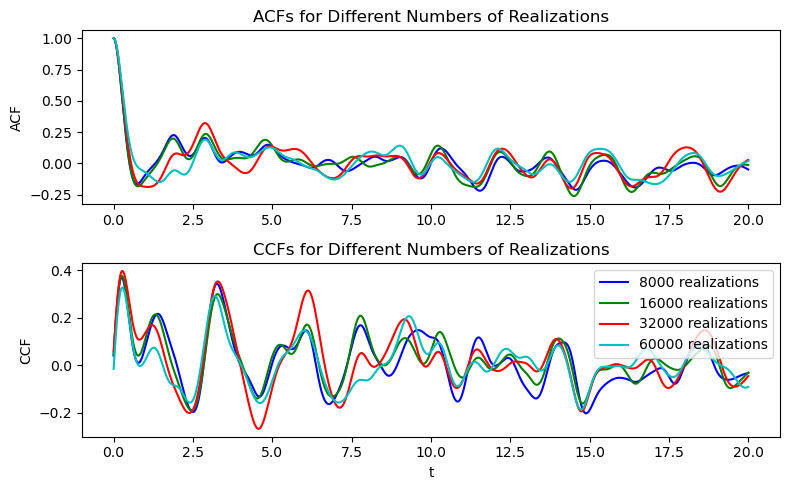

In [12]:
# varies the number of realizations used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [8000, 16000, 32000, 60000]
Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 5; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_hat_t[:,:,:num+Lag], psi2_hat_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)

colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num} realizations' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])

plt.ylabel('ACF')
plt.title('ACFs for Different Numbers of Realizations')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])

plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs for Different Numbers of Realizations')
plt.legend()
plt.tight_layout()
plt.show()

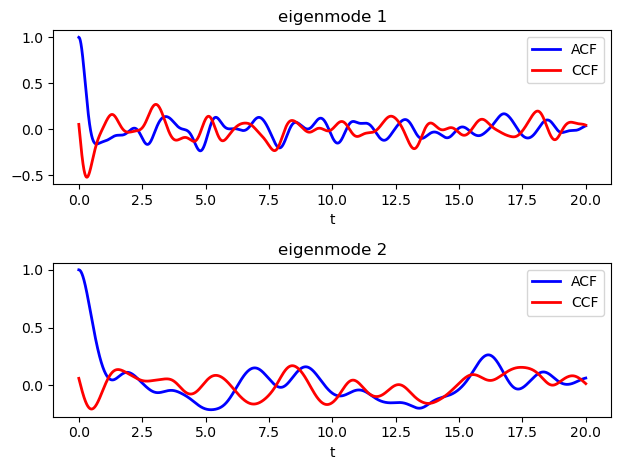

Estimated values:
gamma1, omega1, f1, sigma1
1.8427065852411868, 3.1025812310133087, (-1.9982810473415598+0.5237272340652473j), 22.61225317995604
gamma2, omega2, f2, sigma2
1.07932942215802, 0.7423214150645194, (0.4732955442852069+1.2425861900452086j), 12.331381389649446


In [13]:
# Showing the ACF and the cross-correlation
plt.subplot(2, 1, 1)
plt.plot(tt, acf_psi1, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi1, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 1')
plt.legend()
plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(tt, acf_psi2, 'b', linewidth=2, label='ACF')
plt.plot(tt, ccf_psi2, 'r', linewidth=2, label='CCF')
plt.title('eigenmode 2')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.show()

print('Estimated values:')
print(f'gamma1, omega1, f1, sigma1')
print(f'{gamma1_est}, {omega1_est}, {f1_est}, {sigma1_est}')
print(f'gamma2, omega2, f2, sigma2')
print(f'{gamma2_est}, {omega2_est}, {f2_est}, {sigma2_est}')

In [14]:
np.where(gamma_est < 0)[0].shape

(0,)

In [15]:
# run ou process
# integration parameters
# N = psi1_hat_t.shape[2]
N = 20000
dt = 0.0005
params = np.load('../data/est_paras_ou_K16_beta22.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
cut = 2

# get the initial condition
psi_k = np.zeros((K, K, N), dtype=complex)
tau_k = np.zeros((K, K, N), dtype=complex)
# psi_k[:, :, 0] = (psi1_hat_t[:, :, 0] + psi2_hat_t[:, :, 0]) / 2
# tau_k[:, :, 0] = (psi1_hat_t[:, :, 0] - psi2_hat_t[:, :, 0]) / 2
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,0],psi2_hat_t[iky,ikx,0]])[:,None]
        psi_k[iky,ikx,0] = eigenmode[0] 
        tau_k[iky,ikx,0] = eigenmode[1] # psi_k always use 'xy' indexing

# Numerical integration
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky):  
        if (kx_value == 0 and ky_value==0) or kx_value==-K//2 or ky_value==-K//2: 
            continue 
        for i in range(1, N):
            psi_k[ikx,iky,i] = psi_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * psi_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
            tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())

# Precompute constants
sqrt_dt = np.sqrt(dt)
noise_coeff = sigma/np.sqrt(2) * sqrt_dt
linear_coeff = (-gamma + 1j * omega) * dt
f_coeff = f * dt

# Conditions to skip
skip_indices = np.zeros((K, K), dtype=bool)
skip_indices[0, 0] = True
skip_indices[(K//2-cut):(K//2+cut+1), :] = True
skip_indices[:, (K//2-cut):(K//2+cut+1)] = True

for i in range(1, N):
    psi_k[:, :, i] = psi_k[:, :, i-1] + linear_coeff[:,:,0] * psi_k[:, :, i-1] + f_coeff[:,:,0] + noise_coeff[:,:,0] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    tau_k[:, :, i] = tau_k[:, :, i-1] + linear_coeff[:,:,1] * tau_k[:, :, i-1] + f_coeff[:,:,1] + noise_coeff[:,:,1] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    
    # Apply conditions to skip
    psi_k[skip_indices, i] = psi_k[skip_indices, i-1]
    tau_k[skip_indices, i] = tau_k[skip_indices, i-1]

In [16]:
# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'dt': dt
}
np.savez('../data/ou_run_K16_beta22.npz', **ou_run)

## evaluation

In [4]:
# load data
ou_run = np.load('../data/ou_run_K16_beta22.npz')
N = ou_run['N']
psi_k = ou_run['psi_k'] 
tau_k = ou_run['tau_k']

In [18]:
# ifft to real space
# truth
psi_t_k = np.zeros((K,K,N), dtype='complex')
psi_ifft = np.zeros((K,K,N))
psi_t_ifft = np.zeros((K,K,N))
tau_t_k = np.zeros((K,K,N), dtype='complex')
tau_ifft = np.zeros((K,K,N))
tau_t_ifft = np.zeros((K,K,N))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:N],psi2_hat_t[iky,ikx,:N]])
        psi_t_k[iky,ikx,:] = eigenmode[0,:] 
        tau_t_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing

# truncate Fourier modes
cut = 2
psi_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0
tau_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0

# for i in range(N):
#     psi_ifft[:,:,i] = np.fft.ifft2(psi_k[:, :, i])
#     tau_ifft[:,:,i] = np.fft.ifft2(tau_k[:, :, i])
#     psi_t_ifft[:,:,i] = np.fft.ifft2(psi_t_k[:, :, i])
#     tau_t_ifft[:,:,i] = np.fft.ifft2(tau_t_k[:, :, i])

# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [19]:
# save data
psi_ou_truth = {
    'psi_ifft': psi_ifft,
    'psi_t_ifft': psi_t_ifft,
    'tau_ifft': tau_ifft,
    'tau_t_ifft': tau_t_ifft,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_ou_truth_K16_beta22.npz', **psi_ou_truth)

In [20]:
# save data
psi_k_truth = {
    'psi_t_k': psi_t_k,
    'tau_t_k': tau_t_k,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_k_truth_K16_beta22.npz', **psi_k_truth)

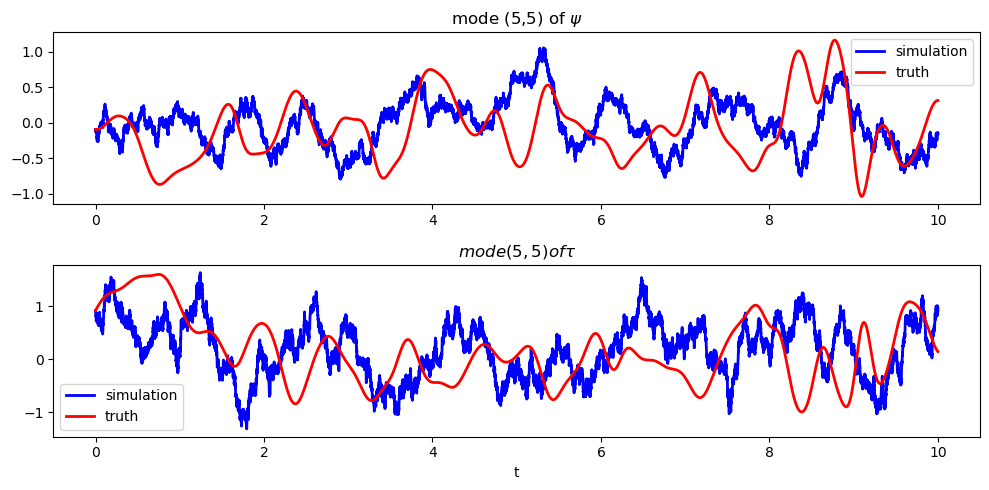

In [22]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title('mode (5,5) of $\psi$')
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$mode (5,5) of  \tau$')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_k_ou_truth_K16_beta22.png', dpi=100)
plt.show()

In [5]:
# load data
file = np.load('../data/psi_k_truth_K16_beta22.npz')
psi_t_k = file['psi_t_k']
tau_t_k = file['tau_t_k']
ou_run = np.load('../data/ou_run_K16_beta22.npz')
psi_k = ou_run['psi_k']
tau_k = ou_run['tau_k']

In [8]:
# energy spectrum
def eigen2layer(K,cut,r1,r2,psi_k,tau_k):
    N = psi_k.shape[-1]
    psi1_k = np.zeros((K,K,N), dtype='complex')
    psi2_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
        eigenmat = np.array([r1[iky,ikx,:],r2[iky,ikx,:]])
        layer = eigenmat @ np.array([psi_k[iky,ikx,:],tau_k[iky,ikx,:]])
        psi1_k[iky,ikx,:] = layer[0,:] 
        psi2_k[iky,ikx,:] = layer[1,:] 
        
    return psi1_k, psi2_k
        
        
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode = np.zeros((K_half + 1,2))
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                E_mode[floor_k, :] += (1 - r) * (np.abs(psi_hat[ii, jj, :])**2)                                
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                    E_mode[ceil_k, :] += r * (np.abs(psi_hat[ii, jj, :])**2)                                

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    E_mode = .5 * E_mode / (K**4)
    
    return KE, APE, E, ETP, E_mode
    

ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
# psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, ie_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += ie_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

# psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
# psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike_ou, iape_ou, iene_ou, ietp_ou, ie_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike_ou
    ape_ou += iape_ou
    ene_ou += iene_ou
    etp_ou += ietp_ou
    e_mode_ou += ie_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

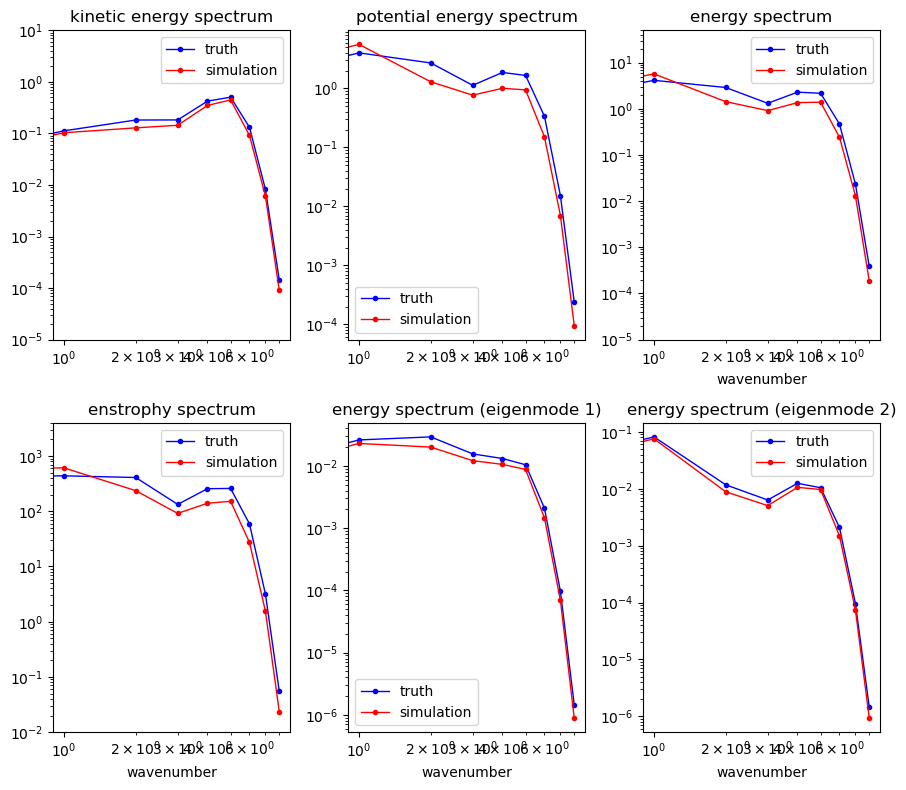

In [11]:
# spectrum 
plt.figure(2, figsize=(9, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 1)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 2)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_eigen_K16_beta22.png', dpi=150)  # Save the figure
plt.show()

In [107]:
# energy spectrum
def eigen2layer(K,cut,r1,r2,psi_k,tau_k):
    N = psi_k.shape[-1]
    psi1_k = np.zeros((K,K,N), dtype='complex')
    psi2_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
            eigenmat = np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T
            layer = eigenmat @ np.array([psi_k[iky,ikx,:],tau_k[iky,ikx,:]])
            psi1_k[iky,ikx,:] = layer[0,:] 
            psi2_k[iky,ikx,:] = layer[1,:] 

    return psi1_k, psi2_k
        
        
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode = np.zeros((K_half + 1,2))
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                E_mode[floor_k, :] += (1 - r) * (np.abs(psi_hat[ii, jj, :])**2)                                
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                    E_mode[ceil_k, :] += r * (np.abs(psi_hat[ii, jj, :])**2)                                

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    E_mode = .5 * E_mode / (K**4)
    
    return KE, APE, E, ETP, E_mode
    

ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
# psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
ke, ape, ene, etp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, ie_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += ie_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

cut = 2
psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
# psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike_ou, iape_ou, iene_ou, ietp_ou, ie_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike_ou
    ape_ou += iape_ou
    ene_ou += iene_ou
    etp_ou += ietp_ou
    e_mode_ou += ie_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

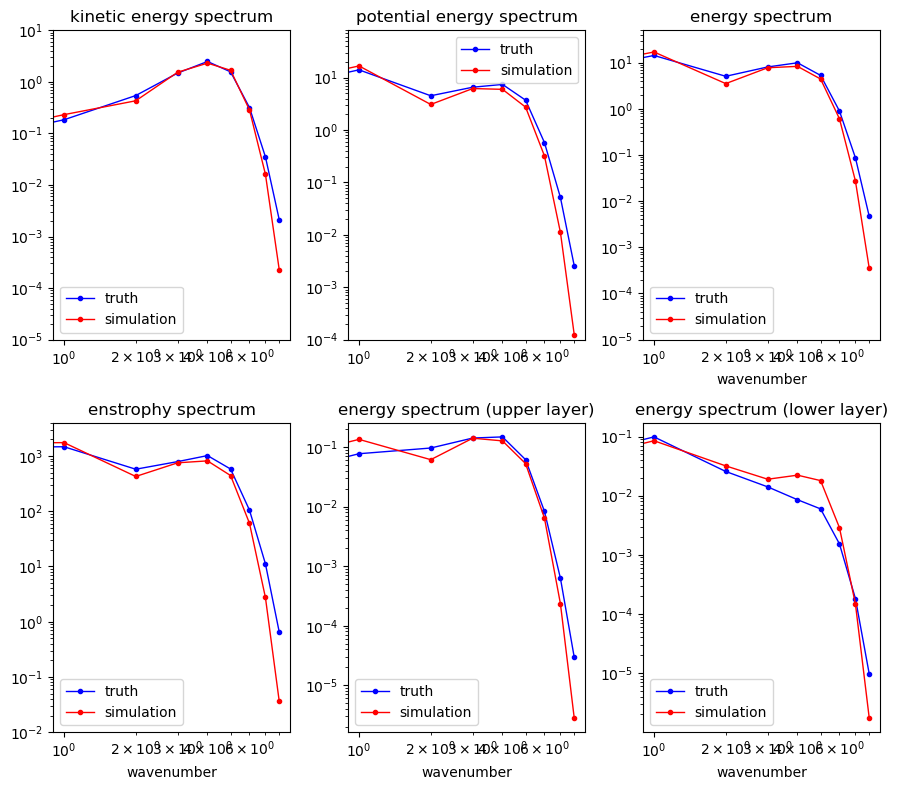

In [108]:
# spectrum 
plt.figure(2, figsize=(9, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-4, 80])
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-9, 4*1e-5])
plt.title('energy spectrum (upper layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-9, 4*1e-5])
plt.title('energy spectrum (lower layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_layer_K16_beta22.png', dpi=150)  # Save the figure
plt.show()

In [100]:
# compute difference
def ene_spectrum1(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode_res = np.zeros(K_half + 1)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)

    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                E_mode_res[floor_k] += (1 - r) * (-2 * (psi_hat[ii, jj, 0].real * psi_hat[ii, jj, 1].real + psi_hat[ii, jj, 0].imag * psi_hat[ii, jj, 1].imag)) 
                                                  #+2 * (psi_hat[ii, jj, 0].real * psi_hat[ii, jj, 0].imag + psi_hat[ii, jj, 1].real * psi_hat[ii, jj, 1].imag)) 
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    E_mode_res[ceil_k] += r * (-2 * (psi_hat[ii, jj, 0].real * psi_hat[ii, jj, 1].real + psi_hat[ii, jj, 0].imag * psi_hat[ii, jj, 1].imag)) 
                                               #+2 * (psi_hat[ii, jj, 0].real * psi_hat[ii, jj, 0].imag + psi_hat[ii, jj, 1].real * psi_hat[ii, jj, 1].imag))                               

    E_mode_res = .5 * E_mode_res / (K**4)
    
    return E_mode_res

psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
e_mode_ou_res = ene_spectrum1(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ie_mode_ou_res = ene_spectrum1(psi_hat[:,:,:,-i], K, kd, topo)
    e_mode_ou_res += ie_mode_ou_res

e_mode_ou_res = e_mode_ou_res / t_avrg

psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
e_mode_res = ene_spectrum1(psi_hat_t[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ie_mode_res = ene_spectrum1(psi_hat_t[:,:,:,-i], K, kd, topo)
    e_mode_res += ie_mode_res

e_mode_res = e_mode_res / t_avrg

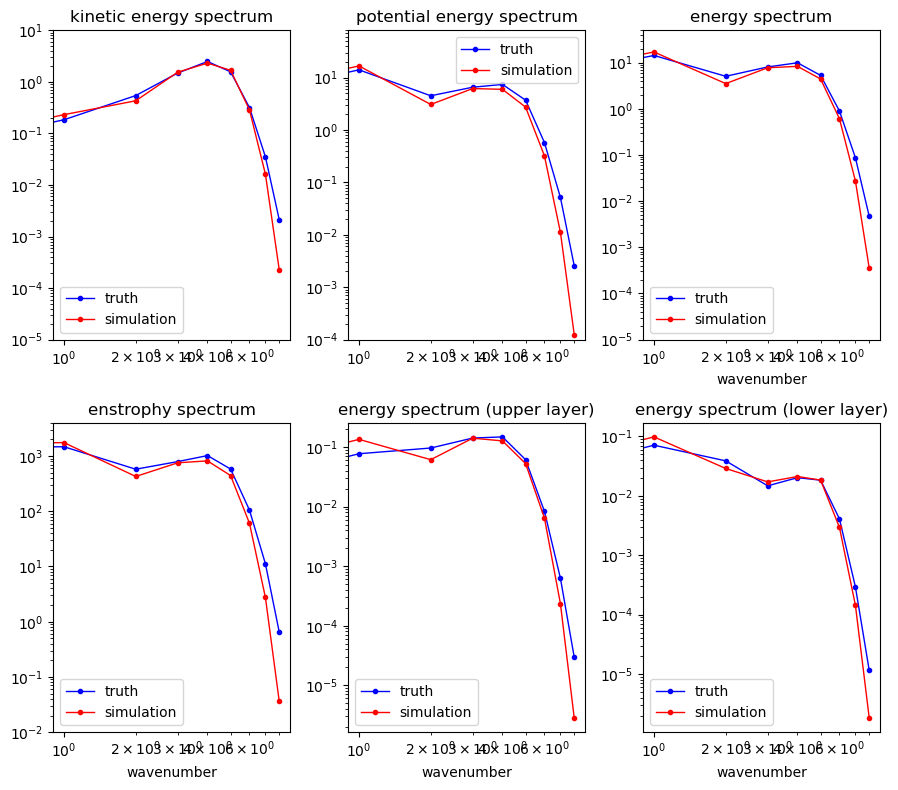

In [109]:
# spectrum 
plt.figure(2, figsize=(9, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-4, 80])
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-9, 4*1e-5])
plt.title('energy spectrum (upper layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1]+e_mode_res.real, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1]+e_mode_ou_res.real, '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-9, 4*1e-5])
plt.title('energy spectrum (lower layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('./LSM/spectrum_layer_K16_beta22.png', dpi=150)  # Save the figure
plt.show()

# 2. Linear QG

The linearized QG model is the same one as used in solving eigenvalues, with only one **difference**: \
**the viscous term** is reserved to prevent the system blow up.

## load data

In [3]:
# load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/linQG_DATA_topo10_beta22_K16.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi1_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    psi2_hat_t = np.transpose(file['psi_2_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    kd = params_dataset['kd'][()] [0,0]
    U = params_dataset['U'][()] [0,0]
    kb = params_dataset['kb'][()] [0,0]
    beta = kb**2
    K = int(params_dataset['N'][()] [0,0])
    H = params_dataset['H'][()] [0,0]
    topo = file['topo'][()]
print('psi_hat_t.shape',psi1_hat_t.shape)
psi1_hat_t = psi1_hat_t['real'] + 1j * psi1_hat_t['imag']
psi2_hat_t = psi2_hat_t['real'] + 1j * psi2_hat_t['imag']
print('psi_hat_t.dtype',psi1_hat_t.dtype)

psi_hat_t.shape (16, 16, 100000)
psi_hat_t.dtype complex128


In [4]:
# load eigenvectors
eigens = np.load('../data/eigens_K16_beta22.npy', allow_pickle=True)
r1 = eigens.item()['r1']
r2 = eigens.item()['r2']
omega1 = eigens.item()['omega1']
omega2 = eigens.item()['omega2']

In [5]:
# Model calibration using eigenmodes recovered based on eigenvectors
#The ansatz of the cross-correlation
def CCF(data, gamma, omega):
    return np.exp(-gamma*data) * np.sin(omega*data)

def ACF(data, gamma, omega):
    return np.exp(-gamma*data) * np.cos(omega*data)


Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
gamma_est = np.zeros((K,K,2))
omega_est = np.zeros((K,K,2))
omega_est_ccf = np.zeros((K,K,2))
f_est = np.zeros((K,K,2), dtype='complex')
sigma_est = np.zeros((K,K,2))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
cut = 0

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        
#         print(kx_value, ky_value)

        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
        psi1_hat = eigenmode[0,:] 
        psi2_hat = eigenmode[1,:]
        acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
        acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
        ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
        ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts

        # Fitting the cross-correlation function
        x0 = [0.5, 0.5]
        x1, _ = curve_fit(ACF, tt, acf_psi1, p0=x0, check_finite=True, maxfev=2000)
        x1_, _ = curve_fit(CCF, tt, ccf_psi1, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma1_est = x1[0]
        omega1_est = x1[1]
        omega1_est_ccf = x1_[1]
        m1 = np.mean(psi1_hat)
        E1 = np.var(psi1_hat)
        T1 = gamma1_est / (gamma1_est**2 + omega1_est**2)
        theta1 = omega1_est / (gamma1_est**2 + omega1_est**2)
        f1_est = m1 * (T1 - 1j*theta1) / (T1**2 + theta1**2)
        sigma1_est = np.sqrt(2*E1*T1 / (T1**2 + theta1**2))
        gamma_est[iky,ikx,0] = gamma1_est; omega_est[iky,ikx,0] = omega1_est; f_est[iky,ikx,0] = f1_est; sigma_est[iky,ikx,0] = sigma1_est;
        omega_est_ccf[iky,ikx,0] = omega1_est_ccf;
        
        x2, _ = curve_fit(ACF, tt, acf_psi2, p0=x0, check_finite=True, maxfev=2000)
        x2_, _ = curve_fit(CCF, tt, ccf_psi2, p0=x0, check_finite=True, maxfev=2000)
        # Estimated values
        gamma2_est = x2[0]
        omega2_est = x2[1]
        omega2_est_ccf = x2_[1]
        m2 = np.mean(psi2_hat)
        E2 = np.var(psi2_hat)
        T2 = gamma2_est / (gamma2_est**2 + omega2_est**2)
        theta2 = omega2_est / (gamma2_est**2 + omega2_est**2)
        f2_est = m2 * (T2 - 1j*theta2) / (T2**2 + theta2**2)
        sigma2_est = np.sqrt(2*E2*T2 / (T2**2 + theta2**2))
        gamma_est[iky,ikx,1] = gamma2_est; omega_est[iky,ikx,1] = omega2_est; f_est[iky,ikx,1] = f2_est; sigma_est[iky,ikx,1] = sigma2_est;
        omega_est_ccf[iky,ikx,1] = omega2_est_ccf;

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [6]:
# calibrate the sign of ACF-estimated omega_k according to CCF-estimated omega_k
sign1 = np.sign(omega_est)
sign2 = np.sign(omega_est_ccf)
sign2_corrected = np.where((sign1 == 0) & (sign2 == 0), 0, sign2)
omega_est_ca = np.abs(omega_est) * sign2_corrected

In [7]:
# save fitted parameters
est_params = {
    'gamma': gamma_est,
    'omega_ccf': omega_est_ccf,
    'omega_acf': omega_est,
    'omega': omega_est_ca,
    'f': f_est,
    'sigma': sigma_est,
    'cut': cut
}
np.save('../data/est_paras_ou_K16_beta22_linQG.npy', est_params)

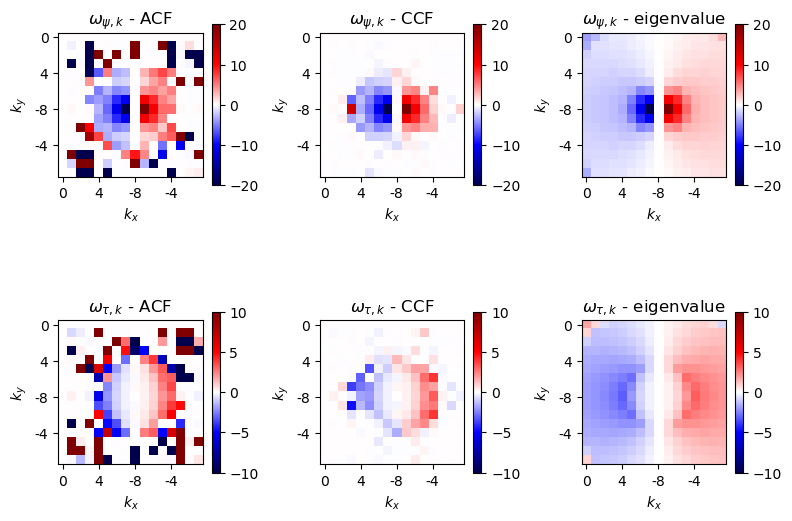

In [8]:
# Create a figure for the plots
fig = plt.figure(figsize=(8, 6))

matrix1 = omega_est_ca[:,:,0]
matrix2 = omega_est_ccf[:,:,0]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)
kx_shift = np.roll(kx, shift=K//2, axis=0) 

lim1 = 20
lim2 = 10
# Plot for matrix1
ax1 = fig.add_subplot(231)  # 1 row, 2 columns, 1st subplot
surf1 = ax1.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax1.set_title(r'$\omega_{\psi,k}$ - ACF')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax1.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_xticklabels(kx[::K//4].astype(int))
ax1.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax1.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1))

# Plot for matrix2
ax2 = fig.add_subplot(232)  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.imshow(matrix2, cmap='seismic', vmin=-lim1, vmax=lim1)
ax2.set_title(r'$\omega_{\psi,k}$ - CCF')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax2.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_xticklabels(kx[::K//4].astype(int))
ax2.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax2.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega_est_ca[:,:,1]
matrix2 = omega_est_ccf[:,:,1]
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax3 = fig.add_subplot(234)  # 1 row, 2 columns, 1st subplot
surf1 = ax3.imshow(matrix1, cmap='seismic', vmin=-lim2, vmax=lim2)
ax3.set_title(r'$\omega_{\tau,k}$ - ACF')
ax3.set_xlabel('$k_x$')
ax3.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax3.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_xticklabels(kx[::K//4].astype(int))
ax3.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax3.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)
# lim1 = np.max(np.abs(matrix1)) / 100

# Plot for matrix2
ax4 = fig.add_subplot(235)  # 1 row, 2 columns, 2nd subplot
surf2 = ax4.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax4.set_title(r'$\omega_{\tau,k}$ - CCF')
ax4.set_xlabel('$k_x$')
ax4.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax4.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_xticklabels(kx[::K//4].astype(int))
ax4.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax4.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

matrix1 = omega1.real # np.abs(omega[:,:,0])-np.abs(omega_est[:,:,0])
matrix2 = omega2.real # p.abs(omega[:,:,1])-np.abs(omega_est[:,:,1])
matrix1 = np.roll(matrix1, shift=K//2, axis=0)
matrix1 = np.roll(matrix1, shift=K//2, axis=1)
matrix2 = np.roll(matrix2, shift=K//2, axis=0) 
matrix2 = np.roll(matrix2, shift=K//2, axis=1)

# Plot for matrix1
ax5 = fig.add_subplot(233)  # 1 row, 2 columns, 1st subplot
surf1 = ax5.imshow(matrix1, cmap='seismic', vmin=-lim1, vmax=lim1)
ax5.set_title(r'$\omega_{\psi,k}$ - eigenvalue')
ax5.set_xlabel('$k_x$')
ax5.set_ylabel('$k_y$')
# ax1.set_zlabel('Value')
ax5.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_xticklabels(kx[::K//4].astype(int))
ax5.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax5.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf1, shrink=0.6)#, ax=ax1, shrink=0.5, aspect=12)

# Plot for matrix2
ax6 = fig.add_subplot(236)  # 1 row, 2 columns, 2nd subplot
surf2 = ax6.imshow(matrix2, cmap='seismic', vmin=-lim2, vmax=lim2)
ax6.set_title(r'$\omega_{\tau,k}$ - eigenvalue')
ax6.set_xlabel('$k_x$')
ax6.set_ylabel('$k_y$')
# ax2.set_zlabel('Value')
# ax2.set_zlim(-60, 60)
ax6.set_xticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_xticklabels(kx[::K//4].astype(int))
ax6.set_yticks(np.linspace(0, K, num=4, endpoint=False))  # Example for 5 ticks
ax6.set_yticklabels(kx[::K//4].astype(int))
fig.colorbar(surf2, shrink=0.6)#, ax=ax2, shrink=0.5, aspect=12)

plt.tight_layout()
plt.savefig('./LSM/omega_compare_K16_linQG.png',dpi=150)
plt.show()

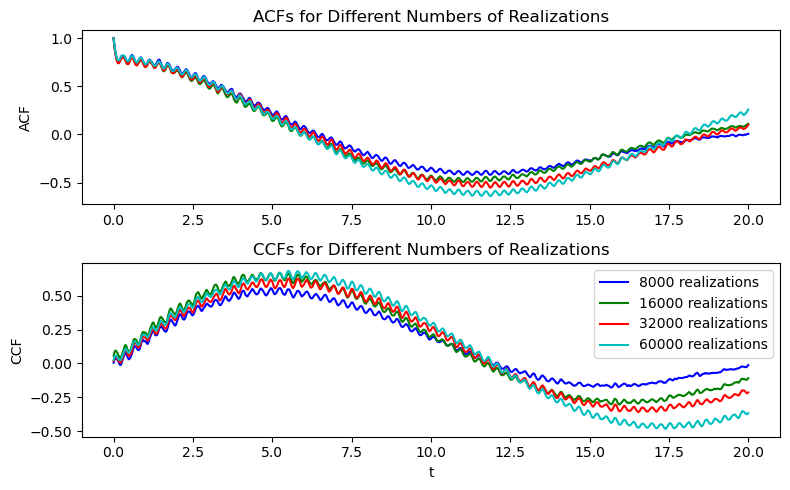

In [9]:
# varies the number of realizations used to estimate ACF    
def cf_eigen(psi1_hat_t, psi2_hat_t, r1, r2, ikx, iky, Lag):
    eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
    eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:],psi2_hat_t[iky,ikx,:]])
    psi1_hat = eigenmode[0,:] 
    psi2_hat = eigenmode[1,:]
    acf_psi1 = acf(np.real(psi1_hat), nlags=Lag, fft=True)  # ACF of the real part
    acf_psi2 = acf(np.real(psi2_hat), nlags=Lag, fft=True)  # ACF of the real part
    ccf_psi1 = -ccf(np.real(psi1_hat), np.imag(psi1_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts 
    ccf_psi2 = -ccf(np.real(psi2_hat), np.imag(psi2_hat), adjusted=False)[:Lag+1]  # cross-correlation between the real and imaginary parts
    
    return acf_psi1, acf_psi2, ccf_psi1, ccf_psi2

nums = [8000, 16000, 32000, 60000]
Lag = 40000  # lag for computing the ACF
tt = np.linspace(0, Lag*dt, num=Lag+1, endpoint=True) # time interval to plot the ACF or cross-correlation function
acf_psi = np.zeros((Lag+1,len(nums)))
acf_tau = np.zeros((Lag+1,len(nums)))
ccf_psi = np.zeros((Lag+1,len(nums)))
ccf_tau = np.zeros((Lag+1,len(nums)))

ikx = 5; iky = 0;
for inum,num in enumerate(nums):
    acf_psi[:,inum], acf_tau[:,inum], ccf_psi[:,inum], ccf_tau[:,inum] = cf_eigen(psi1_hat_t[:,:,:num+Lag], psi2_hat_t[:,:,:num+Lag], r1, r2, ikx, iky, Lag)
    
plt.figure(figsize=(8, 5))  # Set the figure size (optional)

colors = ['b', 'g', 'r', 'c','k']  # Colors for different lines
labels = [f'{num} realizations' for num in nums]  # Labels for the legend

plt.subplot(2, 1, 1)
for i in range(len(nums)):
    plt.plot(tt, acf_psi[:, i], color=colors[i], label=labels[i])

plt.ylabel('ACF')
plt.title('ACFs for Different Numbers of Realizations')

plt.subplot(2, 1, 2)
for i in range(len(nums)):
    plt.plot(tt, ccf_psi[:, i], color=colors[i], label=labels[i])

plt.xlabel('t')
plt.ylabel('CCF')
plt.title('CCFs for Different Numbers of Realizations')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# run ou process
# integration parameters
# N = psi1_hat_t.shape[2]
N = 20000
dt = 0.0005
params = np.load('../data/est_paras_ou_K16_beta22_linQG.npy', allow_pickle=True).item()
gamma, omega, f, sigma = params['gamma'], params['omega'], params['f'], params['sigma']
cut = 2

# get the initial condition
psi_k = np.zeros((K, K, N), dtype=complex)
tau_k = np.zeros((K, K, N), dtype=complex)
# psi_k[:, :, 0] = (psi1_hat_t[:, :, 0] + psi2_hat_t[:, :, 0]) / 2
# tau_k[:, :, 0] = (psi1_hat_t[:, :, 0] - psi2_hat_t[:, :, 0]) / 2
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,0],psi2_hat_t[iky,ikx,0]])[:,None]
        psi_k[iky,ikx,0] = eigenmode[0] 
        tau_k[iky,ikx,0] = eigenmode[1] # psi_k always use 'xy' indexing

# Numerical integration
for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky):  
        if (kx_value == 0 and ky_value==0) or kx_value==-K//2 or ky_value==-K//2: 
            continue 
        for i in range(1, N):
            psi_k[ikx,iky,i] = psi_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * psi_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
            tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())

# Precompute constants
sqrt_dt = np.sqrt(dt)
noise_coeff = sigma/np.sqrt(2) * sqrt_dt
linear_coeff = (-gamma + 1j * omega) * dt
f_coeff = f * dt

# Conditions to skip
skip_indices = np.zeros((K, K), dtype=bool)
skip_indices[0, 0] = True
skip_indices[(K//2-cut):(K//2+cut+1), :] = True
skip_indices[:, (K//2-cut):(K//2+cut+1)] = True

for i in range(1, N):
    psi_k[:, :, i] = psi_k[:, :, i-1] + linear_coeff[:,:,0] * psi_k[:, :, i-1] + f_coeff[:,:,0] + noise_coeff[:,:,0] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    tau_k[:, :, i] = tau_k[:, :, i-1] + linear_coeff[:,:,1] * tau_k[:, :, i-1] + f_coeff[:,:,1] + noise_coeff[:,:,1] * (np.random.randn(K, K) + 1j * np.random.randn(K, K))
    
    # Apply conditions to skip
    psi_k[skip_indices, i] = psi_k[skip_indices, i-1]
    tau_k[skip_indices, i] = tau_k[skip_indices, i-1]

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_13400/60896105.py:31: RuntimeWarning: overflow encountered in scalar multiply
  tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_13400/60896105.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  tau_k[ikx,iky,i] = tau_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * tau_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigma[ikx,iky,0]/np.sqrt(2) * np.sqrt(dt) * (np.random.randn() + 1j * np.random.randn())
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_13400/60896105.py:30: RuntimeWarning: overflow encountered in scalar multiply
  psi_k[ikx,iky,i] = psi_k[ikx,iky,i-1] + (-gamma[ikx,iky,0] + 1j * omega[ikx,iky,0]) * psi_k[ikx,iky,i-1] * dt + f[ikx,iky,0] * dt + sigm

In [11]:
# save data
ou_run = {
    'psi_k': psi_k,
    'tau_k': tau_k,
    'N': N,
    'dt': dt
}
np.savez('../data/ou_run_K16_beta22_linQG.npz', **ou_run)

In [12]:
# load data
ou_run = np.load('../data/ou_run_K16_beta22_linQG.npz')
ou_run.files

['psi_k', 'tau_k', 'N', 'dt']

In [13]:
# ifft to real space
# truth
N = ou_run['N']
psi_k = ou_run['psi_k'] 
psi_t_k = np.zeros((K,K,N), dtype='complex')
psi_ifft = np.zeros((K,K,N))
psi_t_ifft = np.zeros((K,K,N))
tau_k = ou_run['tau_k']
tau_t_k = np.zeros((K,K,N), dtype='complex')
tau_ifft = np.zeros((K,K,N))
tau_t_ifft = np.zeros((K,K,N))
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K

for ikx,kx_value in enumerate(kx):
    for iky,ky_value in enumerate(ky): 
        if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
            continue
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_hat_t[iky,ikx,:N],psi2_hat_t[iky,ikx,:N]])
        psi_t_k[iky,ikx,:] = eigenmode[0,:] 
        tau_t_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing

# truncate Fourier modes
cut = 2
psi_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0
tau_k[K//2-cut:K//2+cut+1,K//2-cut:K//2+cut+1,:] = 0

# for i in range(N):
#     psi_ifft[:,:,i] = np.fft.ifft2(psi_k[:, :, i])
#     tau_ifft[:,:,i] = np.fft.ifft2(tau_k[:, :, i])
#     psi_t_ifft[:,:,i] = np.fft.ifft2(psi_t_k[:, :, i])
#     tau_t_ifft[:,:,i] = np.fft.ifft2(tau_t_k[:, :, i])

# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_ifft = np.roll(psi_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_ifft = np.roll(tau_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# psi_t_ifft = np.roll(psi_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
# tau_t_ifft = np.roll(tau_t_ifft, shift=K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)

In [14]:
# save data
psi_k_truth = {
    'psi_t_k': psi_t_k,
    'tau_t_k': tau_t_k,
    'N': N,
    'cut': cut
}
np.savez('../data/psi_k_truth_K16_beta22_linQG.npz', **psi_k_truth)

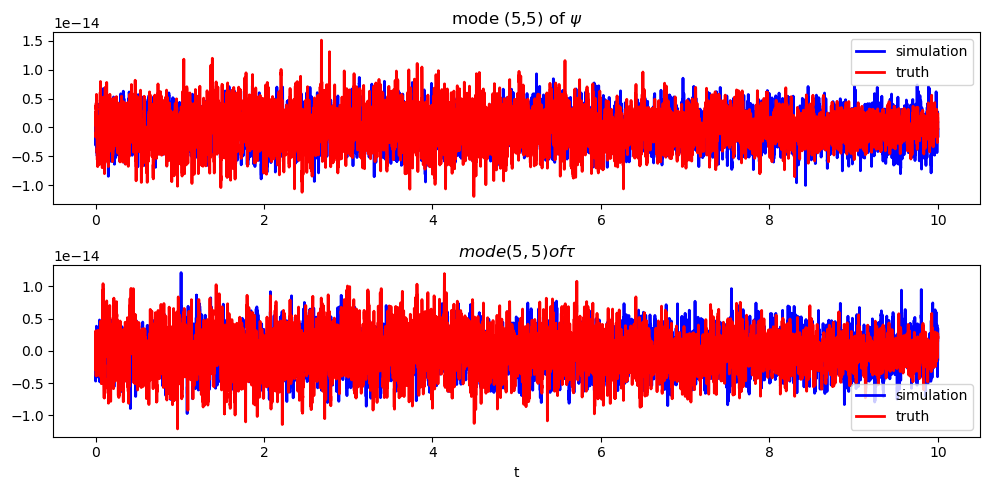

In [15]:
# Plotting trajectories
%matplotlib inline
mode = 5
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(psi_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title('mode (5,5) of $\psi$')
plt.legend()
# plt.xlabel('t')

plt.subplot(2, 1, 2)
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_k[mode,mode,:]), 'b', linewidth=2, label='simulation')
plt.plot(np.arange(dt, (N+1)*dt, dt), np.real(tau_t_k[mode,mode,:]), 'r', linewidth=2, label='truth')
plt.title(r'$mode (5,5) of  \tau$')
plt.legend()
plt.xlabel('t')
plt.tight_layout()
plt.savefig('./LSM/psi_k_ou_truth_K16_beta22_linQG.png', dpi=100)
plt.show()

In [27]:
# energy spectrum
def eigen2layer(K,cut,r1,r2,psi_k,tau_k):
    N = psi_k.shape[-1]
    psi1_k = np.zeros((K,K,N), dtype='complex')
    psi2_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
        eigenmat = np.array([r1[iky,ikx,:],r2[iky,ikx,:]])
        layer = eigenmat @ np.array([psi_k[iky,ikx,:],tau_k[iky,ikx,:]])
        psi1_k[iky,ikx,:] = layer[0,:] 
        psi2_k[iky,ikx,:] = layer[1,:] 
        
    return psi1_k, psi2_k
     
def layer2eigen(K,cut,r1,r2,psi1_k,psi2_k):
    N = psi1_k.shape[-1]
    psi_k = np.zeros((K,K,N), dtype='complex')
    tau_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue         
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_k[iky,ikx,:],psi2_k[iky,ikx,:]])
        psi_k[iky,ikx,:] = eigenmode[0,:] 
        tau_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing        
        
    return psi_k, tau_k
     
        
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode = np.zeros((K_half + 1,2))
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                E_mode[floor_k, :] += (1 - r) * (np.abs(psi_hat[ii, jj, :])**2)                                
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                    E_mode[ceil_k, :] += r * (np.abs(psi_hat[ii, jj, :])**2)                                

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    E_mode = .5 * E_mode / (K**4)
    
    return KE, APE, E, ETP, E_mode
    

ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
# psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += e_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

# psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
# psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike
    ape_ou += iape
    ene_ou += iene
    etp_ou += ietp
    e_mode_ou += e_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

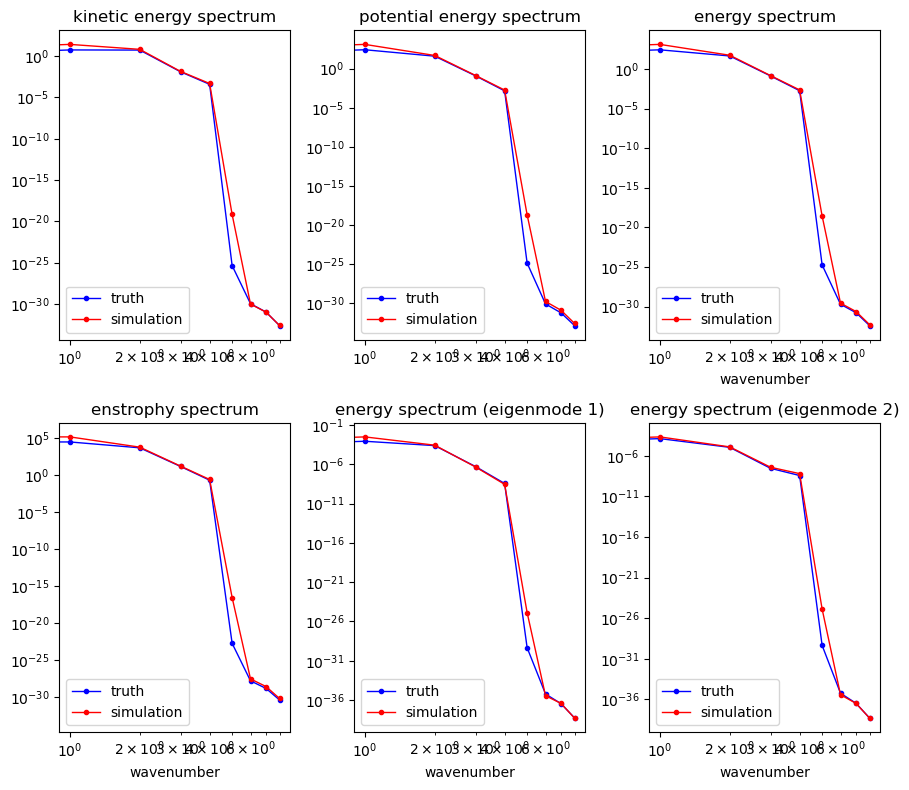

In [28]:
# spectrum of truth
plt.figure(2, figsize=(9, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
# plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 1)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (eigenmode 2)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_eigen_K16_beta22_linQG.png', dpi=150)  # Save the figure
plt.show()

In [29]:
# energy spectrum
def eigen2layer(K,cut,r1,r2,psi_k,tau_k):
    N = psi_k.shape[-1]
    psi1_k = np.zeros((K,K,N), dtype='complex')
    psi2_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue
        eigenmat = np.array([r1[iky,ikx,:],r2[iky,ikx,:]])
        layer = eigenmat @ np.array([psi_k[iky,ikx,:],tau_k[iky,ikx,:]])
        psi1_k[iky,ikx,:] = layer[0,:] 
        psi2_k[iky,ikx,:] = layer[1,:] 
        
    return psi1_k, psi2_k
     
def layer2eigen(K,cut,r1,r2,psi1_k,psi2_k):
    N = psi1_k.shape[-1]
    psi_k = np.zeros((K,K,N), dtype='complex')
    tau_k = np.zeros((K,K,N), dtype='complex')
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    for ikx,kx_value in enumerate(kx):
        for iky,ky_value in enumerate(ky): 
            if (kx_value == 0 and ky_value==0) or abs(kx_value) >= (K//2-cut) or abs(ky_value) >= (K//2-cut):  # Skip the case where k_mag is 0 and truncation
                continue         
        eigenmat_inv = np.linalg.inv(np.array([r1[iky,ikx,:],r2[iky,ikx,:]]).T)
        eigenmode = eigenmat_inv @ np.array([psi1_k[iky,ikx,:],psi2_k[iky,ikx,:]])
        psi_k[iky,ikx,:] = eigenmode[0,:] 
        tau_k[iky,ikx,:] = eigenmode[1,:] # psi_k always use 'xy' indexing        
        
    return psi_k, tau_k
     
        
def ene_spectrum(psi_hat, K, kd, topo):
    hk = np.fft.fft2(topo)
    K_half = K // 2
    E_mode = np.zeros((K_half + 1,2))
    KE = np.zeros(K_half + 1)
    APE = np.zeros_like(KE)
    E = np.zeros_like(KE)
    ETP = np.zeros_like(KE)
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    KX, KY = np.meshgrid(kx, ky)
    
    DY_psi_hat = psi_hat * (1j) * KY[:,:,None]
    DX_psi_hat = psi_hat * (1j) * KX[:,:,None]
    Laplacian = ((1j) * KY)**2 + ((1j) * KX)**2
    q_hat = np.zeros((K,K,2), dtype=complex)
    q_hat[:,:,0] = Laplacian * psi_hat[:,:,0] + kd**2/2*(psi_hat[:,:,1]-psi_hat[:,:,0])
    q_hat[:,:,1] = Laplacian * psi_hat[:,:,1] + kd**2/2*(psi_hat[:,:,0]-psi_hat[:,:,1]) + hk
    
    for jj in range(K):
        for ii in range(K):
            k = np.sqrt(KX[ii, jj]**2 + KY[ii, jj]**2)
            if np.ceil(k) <= K_half:
                r = k - np.floor(k)
                floor_k = int(np.floor(k))
                ceil_k = int(np.ceil(k))

                KE[floor_k] += (1 - r) * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                APE[floor_k] += (1 - r) * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                E[floor_k] += (1 - r) * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                ETP[floor_k] += (1 - r) * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                E_mode[floor_k, :] += (1 - r) * (np.abs(psi_hat[ii, jj, :])**2)                                
                
                if ceil_k != floor_k:  # Only update if ceil(k) and floor(k) are different
                    KE[ceil_k] += r * (k**2) * (np.abs(psi_hat[ii, jj, 0])**2 + np.abs(psi_hat[ii, jj, 1])**2)
                    APE[ceil_k] += r * (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2
                    E[ceil_k] += r * (np.abs(DX_psi_hat[ii, jj, 0])**2 + np.abs(DY_psi_hat[ii, jj, 0])**2 + np.abs(DX_psi_hat[ii, jj, 1])**2 + np.abs(DY_psi_hat[ii, jj, 1])**2 + (.5 * kd**2) * np.abs(psi_hat[ii, jj, 0] - psi_hat[ii, jj, 1])**2)
                    ETP[ceil_k] += r * (np.abs(q_hat[ii, jj, 0])**2 + np.abs(q_hat[ii, jj, 1])**2)
                    E_mode[ceil_k, :] += r * (np.abs(psi_hat[ii, jj, :])**2)                                

    KE = .5 * KE / (K**4)
    APE = .5 * APE / (K**4)
    E = .5 * E / (K**4)
    ETP = .5 * ETP / (K**4)
    E_mode = .5 * E_mode / (K**4)
    
    return KE, APE, E, ETP, E_mode
    

ke=0; ape=0; ene=0; etp=0; ke_ou=0; ape_ou=0; ene_ou=0; etp_ou=0; e_mode = 0; e_mode_ou = 0
t_avrg = 10000
# psi_hat_t = np.concatenate((psi_t_k[:,:,None,-t_avrg:], tau_t_k[:,:,None,-t_avrg:]), axis=2)
psi_hat_t = np.concatenate((psi1_hat_t[:,:,None,-t_avrg:], psi2_hat_t[:,:,None,-t_avrg:]), axis=2)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode = ene_spectrum(psi_hat_t[:,:,:,-i], K, kd, topo)
    ke += ike
    ape += iape
    ene += iene
    etp += ietp 
    e_mode += e_mode
    
ke = ke / t_avrg
ape = ape / t_avrg
ene = ene / t_avrg
etp = etp / t_avrg
e_mode = e_mode / t_avrg

psi1_k, psi2_k = eigen2layer(K,cut,r1,r2,psi_k,tau_k)
psi_hat = np.concatenate((psi1_k[:,:,None,-t_avrg:], psi2_k[:,:,None,-t_avrg:]), axis=2)
# psi_hat = np.concatenate((psi_k[:,:,None,-t_avrg:], tau_k[:,:,None,-t_avrg:]), axis=2)
ke_ou, ape_ou, ene_ou, etp_ou, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-1], K, kd, topo)
for i in range(2,t_avrg+1):
    ike, iape, iene, ietp, e_mode_ou = ene_spectrum(psi_hat[:,:,:,-i], K, kd, topo)
    ke_ou += ike
    ape_ou += iape
    ene_ou += iene
    etp_ou += ietp
    e_mode_ou += e_mode_ou

ke_ou = ke_ou / t_avrg
ape_ou = ape_ou / t_avrg
ene_ou = ene_ou / t_avrg
etp_ou = etp_ou / t_avrg
e_mode_ou = e_mode_ou / t_avrg

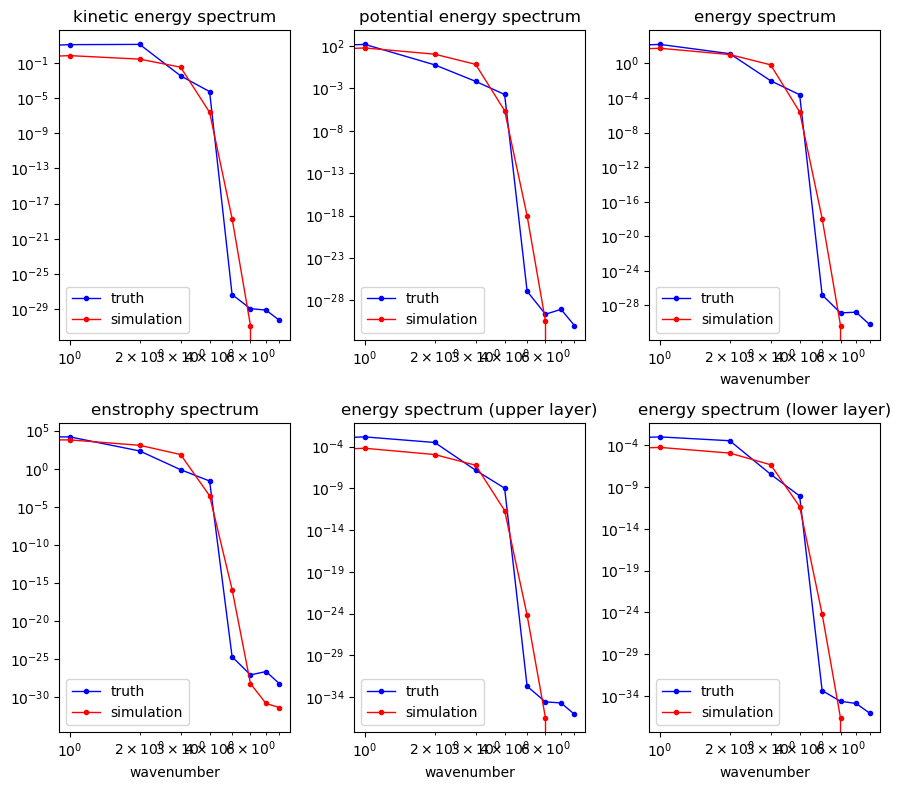

In [31]:
# spectrum of truth
plt.figure(2, figsize=(9, 8))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 1)
plt.loglog(np.arange(0, K//2 + 1), ke, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ke_ou, '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-5, 10])
plt.title('kinetic energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
plt.subplot(2, 3, 2)
plt.loglog(np.arange(0, K//2 + 1), ape, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ape_ou, '.-r', linewidth=1, label='simulation')
plt.title('potential energy spectrum')
plt.legend()
# plt.xlabel('wavenumber')
# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.savefig('energy_topo10_nu2e-15_0228.png', dpi=150)  # Save the figure

# Figure 2
# plt.figure(3, figsize=(6, 4))  # Size in inches, converted from pixels assuming 72 DPI
plt.subplot(2, 3, 3)
plt.loglog(np.arange(0, K//2 + 1), ene, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), ene_ou, '.-r', linewidth=1, label='simulation')
plt.title('energy spectrum')
# plt.ylim([1e-5, 50])
plt.legend()
plt.xlabel('wavenumber')
plt.subplot(2, 3, 4)
plt.loglog(np.arange(0, K//2 + 1), etp, '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), etp_ou, '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('enstrophy spectrum')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 5)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,0], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,0], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (upper layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.subplot(2, 3, 6)
plt.loglog(np.arange(0, K//2 + 1), e_mode[:,1], '.-b', linewidth=1, label='truth')
plt.loglog(np.arange(0, K//2 + 1), e_mode_ou[:,1], '.-r', linewidth=1, label='simulation')
# plt.ylim([1e-2, 4*1e3])
plt.title('energy spectrum (lower layer)')
plt.xlabel('wavenumber')
plt.legend()
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('./LSM/spectrum_layer_K16_beta22_linQG.png', dpi=150)  # Save the figure
plt.show()